In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, plot_importance


warnings.filterwarnings('ignore')

In [66]:
file_path = "C:/Users/samar/OneDrive/Desktop/mathapp/APST/dataChallenge"

In [67]:
away_player_train = file_path + "/Train_Data/train_away_player_statistics_df.csv"
away_team_train = file_path + "/Train_Data/train_away_team_statistics_df.csv"
home_player_train = file_path + "/Train_Data/train_home_player_statistics_df.csv"
home_team_train = file_path + "/Train_Data/train_home_team_statistics_df.csv"

In [68]:
away_player_test = file_path + "/Test_Data/test_away_player_statistics_df.csv"
away_team_test = file_path + "/Test_Data/test_away_team_statistics_df.csv"
home_player_test = file_path + "/Test_Data/test_home_player_statistics_df.csv"
home_team_test = file_path + "/Test_Data/test_home_team_statistics_df.csv"

In [69]:
Y_train_supp = file_path + "/benchmark_and_extras/Y_train_supp.csv"
Y_train = file_path + "/Y_train.csv"
Y_test_random = file_path + "/Y_test_random.csv"

## Read player train data

In [70]:

home_players = pd.read_csv(home_player_train)
away_players = pd.read_csv(away_player_train)

# team_name and league and player_name are not included in the test dataset so no need to use it
home_players = home_players.drop(columns=['TEAM_NAME', 'LEAGUE', 'PLAYER_NAME'])
away_players = away_players.drop(columns=['TEAM_NAME', 'LEAGUE', 'PLAYER_NAME'])

home_players['POSITION'] = home_players['POSITION'].replace({'defender': 1, 'midfielder': 2, 'attacker': 3, 'goalkeeper': 4, '': 0, np.nan: 0})
away_players['POSITION'] = away_players['POSITION'].replace({'defender': 1, 'midfielder': 2, 'attacker': 3, 'goalkeeper': 4, '': 0, np.nan: 0})

In [71]:
# Aggregate player stats by ID and POSITION 
home_team_stats = home_players.groupby(by = ['ID', 'POSITION'], as_index= False).mean().fillna(0)
away_team_stats = away_players.groupby(by = ['ID', 'POSITION'], as_index= False).mean().fillna(0)

team_comparison = pd.merge(home_team_stats, away_team_stats, on=['ID', 'POSITION'], suffixes=('_home', '_away'))


In [72]:
team_comparison.head()

,ID,POSITION,PLAYER_ACCURATE_CROSSES_season_sum_home,PLAYER_ACCURATE_PASSES_season_sum_home,PLAYER_AERIALS_WON_season_sum_home,PLAYER_ASSISTS_season_sum_home,PLAYER_BIG_CHANCES_CREATED_season_sum_home,PLAYER_BIG_CHANCES_MISSED_season_sum_home,PLAYER_BLOCKED_SHOTS_season_sum_home,PLAYER_CAPTAIN_season_sum_home,...,PLAYER_STARTING_LINEUP_5_last_match_std_away,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std_away,PLAYER_TACKLES_5_last_match_std_away,PLAYER_TOTAL_CROSSES_5_last_match_std_away,PLAYER_TOTAL_DUELS_5_last_match_std_away,PLAYER_YELLOWCARDS_5_last_match_std_away,PLAYER_PUNCHES_5_last_match_std_away,PLAYER_LONG_BALLS_5_last_match_std_away,PLAYER_LONG_BALLS_WON_5_last_match_std_away,PLAYER_SHOTS_OFF_TARGET_5_last_match_std_away
0,0,0.0,3.25,12.000000,21.250000,10.500000,6.000000,21.500000,3.000000,0.0,...,36.166667,26.000000,21.000000,25.833333,35.333333,38.5,0.0,0.0,0.0,0.0
1,0,1.0,4.00,27.166667,22.166667,7.000000,5.333333,0.000000,17.500000,0.0,...,17.500000,36.250000,40.000000,17.750000,42.250000,67.5,0.0,0.0,0.0,0.0
2,0,2.0,24.50,23.333333,9.166667,9.333333,12.333333,4.166667,8.166667,45.5,...,28.000000,17.800000,26.200000,9.000000,33.400000,34.2,0.0,0.0,0.0,0.0
3,0,4.0,0.00,16.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,7.000000,0.000000,0.000000,2.000000,0.0,0.0,0.0,0.0,0.0
4,1,0.0,4.00,12.333333,13.000000,40.000000,20.666667,32.666667,2.666667,0.0,...,72.333333,16.666667,6.666667,12.333333,34.666667,0.0,0.0,0.0,0.0,0.0


In [73]:
for column_name in team_comparison.columns:
    if column_name.endswith('_home'):  # Ensure we're processing only '_home' columns
        prefix = column_name[:-5]  # Remove '_home' to get the base column name
        team_comparison[prefix + '_diff'] = (
            team_comparison[column_name] - team_comparison[prefix + '_away']
        )

In [74]:

team_comparison.head()

,ID,POSITION,PLAYER_ACCURATE_CROSSES_season_sum_home,PLAYER_ACCURATE_PASSES_season_sum_home,PLAYER_AERIALS_WON_season_sum_home,PLAYER_ASSISTS_season_sum_home,PLAYER_BIG_CHANCES_CREATED_season_sum_home,PLAYER_BIG_CHANCES_MISSED_season_sum_home,PLAYER_BLOCKED_SHOTS_season_sum_home,PLAYER_CAPTAIN_season_sum_home,...,PLAYER_STARTING_LINEUP_5_last_match_std_diff,PLAYER_SUCCESSFUL_DRIBBLES_5_last_match_std_diff,PLAYER_TACKLES_5_last_match_std_diff,PLAYER_TOTAL_CROSSES_5_last_match_std_diff,PLAYER_TOTAL_DUELS_5_last_match_std_diff,PLAYER_YELLOWCARDS_5_last_match_std_diff,PLAYER_PUNCHES_5_last_match_std_diff,PLAYER_LONG_BALLS_5_last_match_std_diff,PLAYER_LONG_BALLS_WON_5_last_match_std_diff,PLAYER_SHOTS_OFF_TARGET_5_last_match_std_diff
0,0,0.0,3.25,12.000000,21.250000,10.500000,6.000000,21.500000,3.000000,0.0,...,33.833333,-10.500000,-12.000000,-15.583333,5.416667,0.000000,0.0,0.0,0.0,0.0
1,0,1.0,4.00,27.166667,22.166667,7.000000,5.333333,0.000000,17.500000,0.0,...,10.500000,-16.850000,-9.000000,-5.150000,-0.050000,12.900000,0.0,0.0,0.0,0.0
2,0,2.0,24.50,23.333333,9.166667,9.333333,12.333333,4.166667,8.166667,45.5,...,5.833333,23.866667,13.800000,15.333333,14.766667,-8.533333,0.0,0.0,0.0,0.0
3,0,4.0,0.00,16.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,-7.000000,0.000000,0.000000,-0.500000,0.000000,0.0,0.0,0.0,0.0
4,1,0.0,4.00,12.333333,13.000000,40.000000,20.666667,32.666667,2.666667,0.0,...,-72.333333,-9.000000,-2.666667,-7.333333,-16.000000,0.000000,0.0,0.0,0.0,0.0


## Analyse des données

In [75]:
print('dimension of the dataset:', away_players.shape)
print()
away_players.info()

dimension of the dataset: (236132, 304)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236132 entries, 0 to 236131
Columns: 304 entries, ID to PLAYER_SHOTS_OFF_TARGET_5_last_match_std
dtypes: float64(303), int64(1)
memory usage: 547.7 MB


In [76]:
print('dimension of the dataset:', home_players.shape)
print()
home_players.info()

dimension of the dataset: (237079, 304)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237079 entries, 0 to 237078
Columns: 304 entries, ID to PLAYER_SHOTS_OFF_TARGET_5_last_match_std
dtypes: float64(303), int64(1)
memory usage: 549.9 MB


#### Analyse des données manquantes

In [77]:
col_missing_away = away_players.isna().mean().sort_values(ascending=False)
col_missing_away

PLAYER_SHOTS_OFF_TARGET_season_std              1.000000
PLAYER_LONG_BALLS_5_last_match_sum              1.000000
PLAYER_SHOTS_OFF_TARGET_season_sum              1.000000
PLAYER_CAPTAIN_season_average                   1.000000
PLAYER_LONG_BALLS_season_average                1.000000
                                                  ...   
PLAYER_MINUTES_PLAYED_5_last_match_average      0.016216
PLAYER_PENALTIES_SCORED_5_last_match_average    0.016216
PLAYER_STARTING_LINEUP_5_last_match_average     0.016216
POSITION                                        0.000000
ID                                              0.000000
Length: 304, dtype: float64

In [78]:
col_missing_home = home_players.isna().mean().sort_values(ascending=False)
col_missing_home

PLAYER_SHOTS_OFF_TARGET_season_std              1.000000
PLAYER_LONG_BALLS_5_last_match_sum              1.000000
PLAYER_SHOTS_OFF_TARGET_season_sum              1.000000
PLAYER_CAPTAIN_season_average                   1.000000
PLAYER_LONG_BALLS_season_average                1.000000
                                                  ...   
PLAYER_MINUTES_PLAYED_5_last_match_average      0.015172
PLAYER_PENALTIES_SCORED_5_last_match_average    0.015172
PLAYER_STARTING_LINEUP_5_last_match_average     0.015172
POSITION                                        0.000000
ID                                              0.000000
Length: 304, dtype: float64

Nous remarquons un nombre important des colonnes avec des données manquantes

In [79]:
print(f'Percentage de colonnes avec de données manquantes dans away dataset: {len(col_missing_away[col_missing_away > 0])*100/len(col_missing_away):.3f} %')
print(f'Percentage de colonnes avec de données manquantes dans home dataset: {len(col_missing_home[col_missing_home > 0])*100/len(col_missing_home):.3f} %')

Percentage de colonnes avec de données manquantes dans away dataset: 99.342 %
Percentage de colonnes avec de données manquantes dans home dataset: 99.342 %


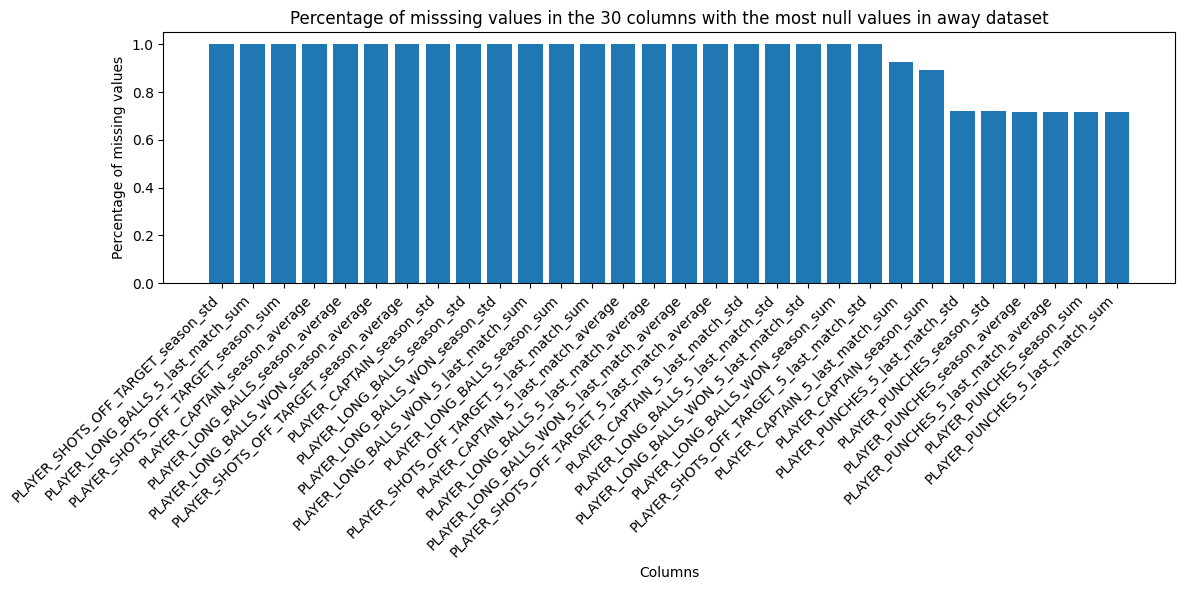

In [80]:
top30_misv = col_missing_away.head(30)
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(top30_misv.index, top30_misv)
ax.set_xticklabels(top30_misv.index, rotation=45, ha='right')
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Percentage of misssing values in the 30 columns with the most null values in away dataset')
plt.tight_layout()
plt.show()

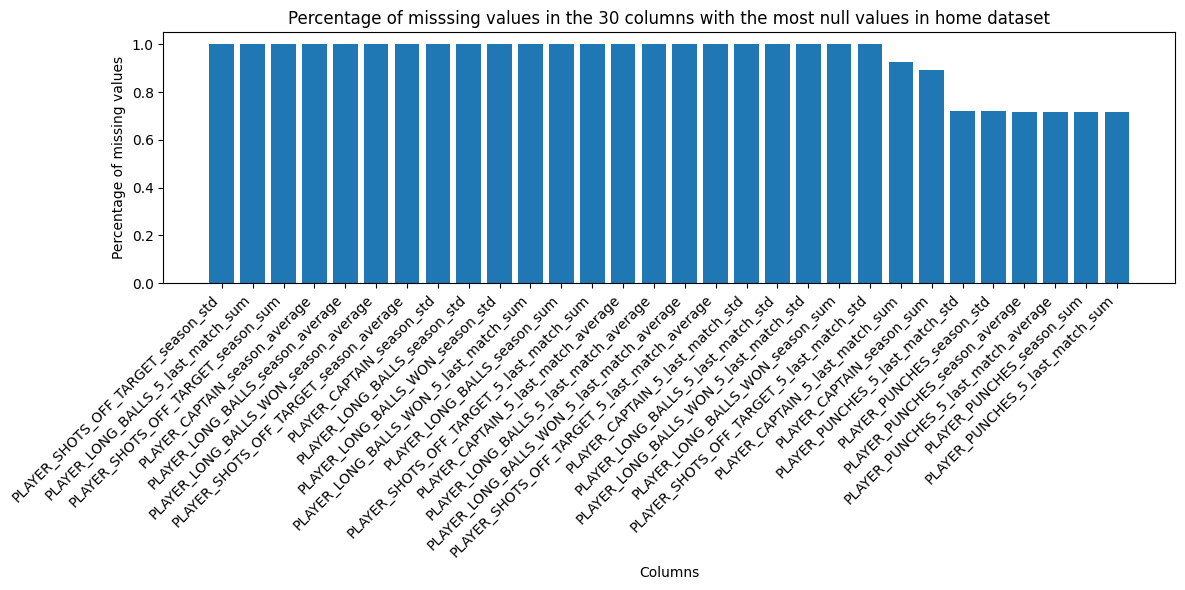

In [81]:
top30_misv = col_missing_away.head(30)
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(top30_misv.index, top30_misv)
ax.set_xticklabels(top30_misv.index, rotation=45, ha='right')
ax.set_xlabel('Columns')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Percentage of misssing values in the 30 columns with the most null values in home dataset')
plt.tight_layout()
plt.show()

On efface les colonnés où il a plus de 30% de données manquantes

In [82]:
cols_drop_away = col_missing_away[col_missing_away > 0.3].index
train_away_clean = away_players.drop(columns=cols_drop_away)
print('Shape initiale:', away_players.shape)
print('Shape finale:',train_away_clean.shape)

Shape initiale: (236132, 304)
Shape finale: (236132, 271)


In [83]:
cols_drop_away = col_missing_home[col_missing_home > 0.3].index
train_home_clean = home_players.drop(columns=cols_drop_away)
print('Shape initiale:', home_players.shape)
print('Shape finale:',train_home_clean.shape)

Shape initiale: (237079, 304)
Shape finale: (237079, 271)


Analyse sur les lignes

In [84]:
row_missing_away = away_players.isna().mean(axis=1).sort_values(ascending=False)
row_missing_away

88026     0.993421
171113    0.993421
90397     0.993421
90418     0.993421
222203    0.993421
            ...   
84078     0.072368
19001     0.072368
160976    0.072368
160966    0.072368
200480    0.072368
Length: 236132, dtype: float64

In [85]:
row_missing_home = home_players.isna().mean(axis=1).sort_values(ascending=False)
row_missing_home

57095     0.993421
156862    0.993421
108771    0.993421
196897    0.993421
196904    0.993421
            ...   
186099    0.072368
96665     0.072368
80991     0.072368
80992     0.072368
43000     0.072368
Length: 237079, dtype: float64

In [86]:
print(f'Percentage de lignes avec de données manquantes: {len(row_missing_away[row_missing_away > 0])*100/len(row_missing_away):.3f} %')
print(f'Percentage de lignes avec de données manquantes: {len(row_missing_home[row_missing_home > 0])*100/len(row_missing_home):.3f} %')

Percentage de lignes avec de données manquantes: 100.000 %
Percentage de lignes avec de données manquantes: 100.000 %


**Nous avons une quantité importante des données manquantes sur chaque ligne**

Dans ce cas, nous analysons les données de test des joeurs

In [87]:
test_player_away = pd.read_csv(away_player_test)

row_missing_awya_test = test_player_away.isna().mean(axis=1).sort_values(ascending=False)
row_missing_awya_test

463137    0.996711
293598    0.996711
299252    0.996711
239328    0.996711
14985     0.996711
            ...   
258513    0.013158
412803    0.013158
361948    0.013158
452679    0.013158
328452    0.013158
Length: 504626, dtype: float64

In [88]:
test_player_home = pd.read_csv(home_player_test)
row_missing_home_test = test_player_home.isna().mean(axis=1).sort_values(ascending=False)
row_missing_home_test

400724    0.996711
427524    0.996711
411962    0.996711
386509    0.996711
271283    0.996711
            ...   
224513    0.013158
224511    0.013158
442985    0.013158
101602    0.013158
128269    0.013158
Length: 509816, dtype: float64

In [89]:
print(f'Percentage de lignes avec de données manquantes: {len(row_missing_awya_test[row_missing_awya_test > 0])*100/len(row_missing_awya_test):.3f} %')
print(f'Percentage de lignes avec de données manquantes: {len(row_missing_home_test[row_missing_home_test > 0])*100/len(row_missing_home_test):.3f} %')

Percentage de lignes avec de données manquantes: 100.000 %
Percentage de lignes avec de données manquantes: 100.000 %


Nous remarquons que dans les données de test il y a également beaucoup de données manquantes, avec des lignes qui manquent plus de 90% des données. 

Dans ce cas, une imputation de données n'a pas du sense car dans certains cas nous allons imputer presque toute la ligne.
Donc, les données des joueurs ne seront pas accurate mais en va quand même essayer de voir l'accuracy des predictions avec les datasets des joueurs.

## Entraînement de modèles

In [90]:
# Load labels
labels = pd.read_csv(Y_train)

# Merge with features
data_with_labels = pd.merge(team_comparison, labels, how='right', on='ID')

In [91]:
data_with_labels.head()

,ID,POSITION,PLAYER_ACCURATE_CROSSES_season_sum_home,PLAYER_ACCURATE_PASSES_season_sum_home,PLAYER_AERIALS_WON_season_sum_home,PLAYER_ASSISTS_season_sum_home,PLAYER_BIG_CHANCES_CREATED_season_sum_home,PLAYER_BIG_CHANCES_MISSED_season_sum_home,PLAYER_BLOCKED_SHOTS_season_sum_home,PLAYER_CAPTAIN_season_sum_home,...,PLAYER_TOTAL_CROSSES_5_last_match_std_diff,PLAYER_TOTAL_DUELS_5_last_match_std_diff,PLAYER_YELLOWCARDS_5_last_match_std_diff,PLAYER_PUNCHES_5_last_match_std_diff,PLAYER_LONG_BALLS_5_last_match_std_diff,PLAYER_LONG_BALLS_WON_5_last_match_std_diff,PLAYER_SHOTS_OFF_TARGET_5_last_match_std_diff,HOME_WINS,DRAW,AWAY_WINS
0,0,0.0,3.25,12.000000,21.250000,10.500000,6.000000,21.500000,3.000000,0.0,...,-15.583333,5.416667,0.000000,0.0,0.0,0.0,0.0,0,0,1
1,0,1.0,4.00,27.166667,22.166667,7.000000,5.333333,0.000000,17.500000,0.0,...,-5.150000,-0.050000,12.900000,0.0,0.0,0.0,0.0,0,0,1
2,0,2.0,24.50,23.333333,9.166667,9.333333,12.333333,4.166667,8.166667,45.5,...,15.333333,14.766667,-8.533333,0.0,0.0,0.0,0.0,0,0,1
3,0,4.0,0.00,16.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,-0.500000,0.000000,0.0,0.0,0.0,0.0,0,0,1
4,1,0.0,4.00,12.333333,13.000000,40.000000,20.666667,32.666667,2.666667,0.0,...,-7.333333,-16.000000,0.000000,0.0,0.0,0.0,0.0,0,1,0


In [92]:
# Split data
X = data_with_labels.drop(['HOME_WINS', 'DRAW', 'AWAY_WINS'], axis=1).fillna(0)
y = data_with_labels[['HOME_WINS', 'DRAW', 'AWAY_WINS']].values.argmax(axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [93]:
print(f"Nombre de données d'entrainement: {X_train.shape[0]}")
print(f"Nombre de données de test: {X_val.shape[0]}")

Nombre de données d'entrainement: 36912
Nombre de données de test: 9228


In [94]:
y_train

array([2, 0, 1, ..., 0, 1, 0], dtype=int64)

### Imputation et standardisation des données

In [95]:
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)

### Gradient Boosting Classifier

In [99]:
params1 = {
    'n_estimators': 200,
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.9,
    'random_state': 42
}
gb_model = GradientBoostingClassifier(**params1)


In [ ]:
gb_model.fit(X_train, y_train)


In [ ]:
y_pred = gb_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))

In [ ]:
y_pred

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

find imporatance of the features

In [ ]:
# Model and Hyperparameter Tuning to improve the model
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [5, 7, 8],
    'subsample': [0.8, 0.9, 1]
}

gb_model = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(
    gb_model, param_grid=params, scoring='accuracy', cv=3, verbose=1, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Evaluate Model
best_model_gb = grid_search.best_estimator_
best_model_gb_accuracy = y_pred = best_model_gb.predict(X_val)
accuracy_score(y_val, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

In [ ]:
best_model_gb_accuracy = y_pred = best_model_gb.predict(X_val)

In [ ]:
# Feature Importance
importances = best_model_gb.feature_importances_
feature_names = X_train.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(25)
print("Top 10 Features:\n", feature_importance)

In [ ]:
max_num_features = 25
top_features = feature_importance.head(max_num_features)

plt.figure(figsize=(10, 10))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f'Top {max_num_features} Most Important Features in Random Forest')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

In [ ]:
n_features = X_train.shape[1]
total_pairs = n_features * (n_features - 1) // 2

correlation_matrix = X_train.corr()
high_corr_pairs = np.sum(np.triu(correlation_matrix > 0.9, k=1))

percentage_high_corr = (high_corr_pairs / total_pairs) * 100

print(f"Nombre total de paires: {total_pairs}")
print(f"Nombre de paires avec une corrélation > 0,9: {high_corr_pairs}")
print(f"Pourcentage de paires fortement corrélées: {percentage_high_corr:.2f}%")

In [ ]:
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_val)

print(f"Nombre de composantes principales: {X_train_pca.shape[1]}")

In [ ]:
threshold = 0.003  
important_features = feature_importance[feature_importance['Importance'] > threshold]

print(f"Nombre de features sélectionnées: {len(important_features)}")

selected_features_gb = important_features['Feature'].tolist()

X_train_selected = X_train[selected_features_gb]
X_test_selected = X_val[selected_features_gb]

In [ ]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.9,
    'random_state': 42
}
gb_model_selected = GradientBoostingClassifier(**params)
gb_model_selected.fit(X_train_selected, y_train)
y_pred = gb_model_selected.predict(X_test_selected)

In [ ]:
y_pred_selected = gb_model_selected.predict(X_test_selected)
score_gb_selected = accuracy_score(y_val, y_pred_selected)
score_gb_selected

##### improve the model

In [ ]:
params = {
    'n_estimators': 200,
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.9,
    'random_state': 42
}
model = GradientBoostingClassifier(**params)
model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
#Ensure consistent scaling for feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.4845036844386649


In [ ]:
#Use SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.4620719549198093


In [ ]:
#Reduce noise by selecting relevant features

from sklearn.feature_selection import SelectFromModel

feature_selector = SelectFromModel(model, threshold='median')
X_train_selected = feature_selector.fit_transform(X_train, y_train)
X_val_selected = feature_selector.transform(X_val)

model.fit(X_train_selected, y_train)
y_pred = model.predict(X_val_selected)
print("Accuracy with Feature Selection:", accuracy_score(y_val, y_pred))

In [ ]:
#Use early stopping to avoid overfitting
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=10
)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))

In [ ]:
cm = confusion_matrix(y_val, y_pred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['HOME_WINS', 'DRAW', 'AWAY_WINS']).plot()

Nous pouvons remarquer avec les figures ci-dessus l'évolution du score par rapport au nombre de voisins pour chaque métrique utilisé. Nous observons l'effet du overfitting quand nous avons un nombre des voisins faibles. C'est possible de remarquer aussi une stabilisation de l'évolution du score après 100 voisins.!!!!!

### XGBClassifier

Highly efficient for tabular data and supports multi-class classification. Offers regularization for better generalization.

In [ ]:
# Optimize Model Parameters 
from sklearn.model_selection import GridSearchCV
import xgboost

param_grid = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.025, 0.05],
    'n_estimators': [500, 1000],
    'colsample_bytree': [0.6, 0.8],
    'subsample': [0.8, 1.0],
}
grid_search = GridSearchCV(xgboost.XGBClassifier(objective='multi:softprob', num_class=3), param_grid, cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

In [ ]:
params_1 = {
    'max_depth': 10,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'colsample_bytree': 0.8,
    'subsample': 1.0,
}
modelXGB = xgb.XGBClassifier(params_1)
modelXGB.fit(X_train, y_train)

# Evaluate
y_pred = modelXGB.predict(X_val) 
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.4710663198959688


In [ ]:
cm = confusion_matrix(y_val, y_pred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['HOME_WINS', 'DRAW', 'AWAY_WINS']).plot()

In [ ]:
#SHAP values can explain the influence of each feature (and its values) on individual predictions.
import shap

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(modelXGB)
shap_values = explainer.shap_values(X_train)

# Visualize for 'POSITION'
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

### Random Forest Classifier

Captures non-linear relationships and works well with feature importance analysis.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_preds)
print("Accuracy:", rf_accuracy)

Accuracy: 0.4755093194625054


In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
grid_search_rf.fit(X_train, y_train)
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")

Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Random Forest Classifier
rf_model_improved = RandomForestClassifier(n_estimators= 100, random_state= 42, max_depth= 10, min_samples_split= 2)
rf_model_improved.fit(X_train, y_train)
rf_preds = rf_model_improved.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_preds)
print("Accuracy:", rf_accuracy)

Accuracy: 0.4822280017338535


In [ ]:
rf_preds

array([0, 2, 0, ..., 2, 2, 0])

### Logistic Regression

Simple and interpretable, suitable if the relationships are mostly linear.

In [ ]:
from sklearn.linear_model import LogisticRegression
model_logistic_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
model_logistic_reg.fit(X_train, y_train)
y_pred = model_logistic_reg.predict(X_val)

In [ ]:
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.47919375812743825


### Neural Networks

Effective if your dataset is large and complex. Can model interactions between features that traditional models might miss.

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.39434330299089726


###  Ensemble Methods

Combine predictions from multiple models (e.g., Random Forest + Gradient Boosting) to improve robustness.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(random_state=42)
model2 = GradientBoostingClassifier(random_state=42)
ensemble = VotingClassifier(estimators=[('rf', model1), ('gb', model2)], voting='soft')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.48255309926311224


### Support Vector Machine (SVM)

Effective for smaller datasets with clear class boundaries but may not scale well.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
svm_preds = svm_model.predict(X_val)

# Evaluate the model
svm_accuracy = accuracy_score(y_val, svm_preds)
print("SVM Accuracy:", svm_accuracy)

SVM Accuracy: 0.4359557867360208


### CatBoost

Handles categorical features without requiring one-hot encoding and is robust for tabular data.

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, random_seed=42, verbose=0)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
catboost_preds = catboost_model.predict(X_val)

# Evaluate the model
catboost_accuracy = accuracy_score(y_val, catboost_preds)
print("CatBoost Accuracy:", catboost_accuracy)

ModuleNotFoundError: No module named 'catboost'

### K-Nearest Neighbors (KNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
knn_preds = knn_model.predict(X_val)

# Evaluate the model
knn_accuracy = accuracy_score(y_val, knn_preds)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.41211530125704376


## Analyse du Score

In [ ]:
pd.DataFrame(
    {'score': [score_knn, score_xgb, score_xgb_var_imp, score_lgb, score_reglog, score_reglog_hyp, score_rf, score_rf_nb, score_rf_selected]},  
    index=['KNN Score', 'XGB Score', 'XGB Variable Importance Score', 'LGBM Score', 'Reg Logistique Score',
            'Reg Logistique Opt Hyparam', 'Random Forest Score', 'Random Forest No Bootstrap Score', 
            'Random Forest Selected Features']).sort_values(by='score', ascending=False)

#### Submission

In [ ]:
home_players_test = pd.read_csv(home_player_test)
away_players_test = pd.read_csv(away_player_test)

num_distinct_ids = home_players_test['ID'].nunique()
num_distinct_ids1 = away_players_test['ID'].nunique()

25368 25368


In [ ]:
home_players_test['POSITION'] = home_players_test['POSITION'].replace({'defender': 1, 'midfielder': 2, 'attacker': 3, 'goalkeeper': 4, '': 0, np.nan: 0})
away_players_test['POSITION'] = away_players_test['POSITION'].replace({'defender': 1, 'midfielder': 2, 'attacker': 3, 'goalkeeper': 4, '': 0, np.nan: 0})

num_distinct_ids2 = home_players_test['ID'].nunique()
num_distinct_ids3 = away_players_test['ID'].nunique()

25368 25368


In [57]:
# Aggregate player stats by ID and POSITION 
home_team_stats = home_players_test.groupby(by = ['ID', 'POSITION'], as_index=False).mean()
away_team_stats = away_players_test.groupby(by = ['ID', 'POSITION'], as_index=False).mean()

In [75]:
# Merge on match ID and POSITION
team_comparison_test = pd.merge(home_team_stats, away_team_stats, on=['ID', 'POSITION'], suffixes=('_home', '_away'), how='outer').fillna(0)

In [76]:
for column_name in team_comparison_test.columns:
    if column_name.endswith('_home'):  # Ensure we're processing only '_home' columns
        prefix = column_name[:-5]  # Remove '_home' to get the base column name
        team_comparison_test[prefix + '_diff'] = (
            team_comparison_test[column_name] - team_comparison_test[prefix + '_away']
        )


In [ ]:
def generate_test_submission(model):
    predictions = model.predict(team_comparison_test)
    team_comparison_test.set_index('ID', inplace=True)
    predictions_sub = np.zeros((predictions.size, 3))
    for i in range(predictions.size):
        predictions_sub[i][predictions[i]] = 1
    predictions_sub = pd.DataFrame(predictions_sub, dtype=int)
    predictions_sub.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']

    predictions_sub.index = team_comparison_test.index
    submission = predictions_sub.reset_index()
    submission = submission.groupby('ID').sum().div(4).round().astype(int).reset_index()
    return submission

#### Gradient Boosting submission

In [ ]:
GB_submission = generate_test_submission(model)
GB_submission.to_csv(file_path + "/submission_gb.csv", index=False)

#### RF Submission

In [ ]:
RF_submission = generate_test_submission(rf_model_improved)
RF_submission.to_csv(file_path + "/submission_rf.csv", index=False)

array([0, 2, 0, ..., 0, 0, 0], dtype=int64)

#### Logistic Regression submission

In [ ]:
logistic_reg_submission = generate_test_submission(model_logistic_reg)
logistic_reg_submission.to_csv(file_path + "/submission_logistic_reg.csv", index=False)

#### Ensemble Methods submission

In [ ]:
ensemble_submission = generate_test_submission(ensemble)
ensemble_submission.to_csv(file_path + "/submission_logistic_reg.csv", index=False) #0.40917691579943233 

,ID,HOME_WINS,DRAW,AWAY_WINS
0,12303,1,0,0
1,12304,1,0,0
2,12305,1,0,0
3,12306,1,0,0
4,12307,1,0,0
...,...,...,...,...
25363,37666,1,0,0
25364,37667,1,0,0
25365,37668,1,0,0
25366,37669,1,0,0


#### XGBClassifier submission

In [ ]:
xgb_submission = generate_test_submission(modelXGB)
xgb_submission.to_csv(file_path + "/submission_logistic_reg.csv", index=False)